In [2]:
%cd "~/pln-brca-xp/notebooks"
%load_ext autoreload
%autoreload 2

/home/xabush/pln-brca-xp/notebooks


In [3]:

from utils_emb import *
import diffxpy.api as de
import anndata
from goatools.cli.find_enrichment import GoeaCliFnc
import collections as cx

In [4]:
st_df = pd.read_csv("/var/www/datasets/embedding_vector_state_and_outcome.csv", index_col="patient_ID")
ge_df = pd.read_csv("/var/www/datasets/merged-combat15.csv.xz", index_col="patient_ID")


In [6]:
tamoxifen_studies_v2 = ["GSE12093",  "GSE1379", "GSE17705", "GSE9893"]
st_tamx_df = st_df[st_df["series_id"].isin(tamoxifen_studies_v2)]
ge_out_df = ge_df.join(st_df["posOutcome"])
ge_tamx_df = ge_df.loc[st_tamx_df.index,:]
ge_out_tamx_df = ge_tamx_df.join(st_df["posOutcome"])

In [7]:
X, y = ge_tamx_df, ge_out_tamx_df["posOutcome"]
print(X.shape)

(649, 8832)


In [8]:

data = anndata.AnnData(
    X=X.values,
    var=pd.DataFrame(index=X.columns.to_list()),
    obs=y.to_frame()
)

test_t = de.test.t_test(
    data=data,
    grouping="posOutcome",
    is_logged=True
)

/home/xabush/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


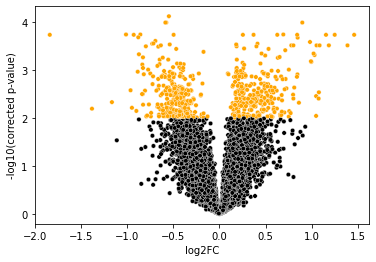

In [10]:
test_t.plot_volcano(min_fc=1.05, alpha=0.01, size=20)

In [11]:
test_t_df = test_t.summary(qval_thres=0.01).sort_values(by="log2fc")
display(test_t_df)

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
1958,S100P,3.601342e-07,0.000187,-1.835997,7.524859,False,False
2367,SCGB2A1,3.172131e-04,0.006453,-1.379571,5.813247,False,False
1979,MMP1,1.897892e-04,0.004718,-1.163665,4.853581,False,False
3747,AURKA,1.461235e-07,0.000184,-1.011197,5.615267,False,False
1615,CRABP2,6.268897e-05,0.002667,-0.961584,9.279208,False,False
...,...,...,...,...,...,...,...
7127,PTN,2.866179e-07,0.000187,1.153261,5.793716,False,False
6538,NTRK2,1.132639e-06,0.000310,1.184672,5.276871,False,False
3318,ABAT,3.452291e-07,0.000187,1.247888,6.401423,False,False
7994,STC2,1.158586e-06,0.000310,1.385990,6.368109,False,False


In [15]:
feat_diff_exp = test_t.summary(qval_thres=0.01).sort_values(by="log2fc")["gene"].to_list()
len(feat_diff_exp)

622

In [16]:
with open("datasets/feat_diff_exp.txt", "w") as fp:
    print_array(feat_diff_exp, fp)


In [121]:
log_pos_genes = test_t_df[test_t_df["log2fc"] > 0]["gene"].to_list()
log_neg_genes = test_t_df[test_t_df["log2fc"] < 0]["gene"].to_list()

In [14]:
pop_genes = X.columns.to_list()
# pop_genes = [x for x in X_17705.columns.to_list() if x not in feat_diff_exp]
len(pop_genes)

8832

In [15]:
from convert_symbol_to_entrez import convert_symbol_to_geneid, read_symbol2geneid

sym2geneid = read_symbol2geneid("datasets/Homo_sapiens.gene_info")

  126,696 READ: datasets/Homo_sapiens.gene_info


In [16]:
feat_diff_exp_ids = convert_symbol_to_geneid(feat_diff_exp, sym2geneid)
feats_all_ids = convert_symbol_to_geneid(pop_genes, sym2geneid)

In [122]:
log_pos_genes_ids = convert_symbol_to_geneid(log_pos_genes, sym2geneid)
log_neg_genes_ids = convert_symbol_to_geneid(log_neg_genes, sym2geneid)

In [17]:
with open("datasets/feat_diff_exp_tx_id.txt", "w") as fp:
    print_array(feat_diff_exp_ids, fp)

In [45]:

opt = {
    'annofmt': None,
    'alpha' : 0.05,
    'compare' : False,
    'filenames' : ['datasets/feat_diff_exp_tx_id.txt',
                    'datasets/feat_all_ids.txt', 'gene2go'],
    'goslim' : 'datasets/goslim_generic.obo',
    'indent' : False,
    'method' : 'bonferroni,sidak,holm,fdr_bh',
    # 'method': 'fdr_bh',
    'min_overlap' : 0.7,
    'no_propagate_counts' : False,
    'obo' : 'datasets/go-basic.obo',
    'outfile' : 'datasets/goea_tx_bp.txt',
    'outfile_detail' : None,
    'ns': 'BP,MF,CC',
    'pval' : 0.05,
    'pval_field' : 'uncorrected',
    'pvalcalc' : 'fisher',
    'ratio' : None,
    'relationship': True,
    'relationships': None,
    'sections' : None,
    'ev_inc': None,
    'ev_exc': None,
    'taxid': 9606
    # BROAD 'remove_goids': None,
}
args = cx.namedtuple("Namespace", " ".join(opt.keys()))
args = args(**opt)

In [47]:
goea = GoeaCliFnc(args)
res = goea.get_results_sig()

goea.prt_outfiles_flat(res, ['datasets/goea_tx.tsv'])

datasets/go-basic.obo: fmt(1.2) rel(2021-02-01) 47,291 GO Terms; optional_attrs(relationship)
HMS:0:00:04.631434 335,863 annotations, 20,672 genes, 18,441 GOs, 1 taxids READ: gene2go 
Study: 1514 vs. Population 8822


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 96%  8,450 of  8,822 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 98%  8,611 of  8,822 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 97%  8,539 of  8,822 population items found in association

Run BP Gene Ontology Analysis: current study set of 1514 IDs ... 95%  1,441 of  1,514 study items found in association
100%  1,514 of  1,514 study items found in population(8822)
Cal

In [48]:
goea_df = pd.read_table('datasets/goea_tx.tsv')
display(goea_df)

,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_bonferroni,p_sidak,p_holm,p_fdr_bh,study_items
0,GO:0009583,BP,e,detection of light stimulus,19/1514,34/8822,3.481719e-07,5,19,0.004911,0.004787,0.004910,0.001228,"24, 778, 1258, 2779, 2792, 2916, 2978, 5148, 5..."
1,GO:0009581,BP,e,detection of external stimulus,28/1514,70/8822,6.651598e-06,3,28,0.093821,0.091455,0.093768,0.009281,"24, 778, 1000, 1258, 2047, 2779, 2792, 2916, 2..."
2,GO:0009582,BP,e,detection of abiotic stimulus,28/1514,72/8822,1.046112e-05,3,28,0.147554,0.143834,0.147439,0.012296,"24, 778, 1000, 1258, 2047, 2779, 2792, 2916, 2..."
3,GO:0007602,BP,e,phototransduction,14/1514,27/8822,3.911066e-05,6,14,0.551656,0.537748,0.551108,0.035153,"24, 1258, 2779, 2792, 2978, 5148, 5158, 5995, ..."
4,GO:0072503,BP,e,cellular divalent inorganic cation homeostasis,78/1514,300/8822,8.890656e-05,8,78,1.000000,1.000000,1.000000,0.059716,"116, 146, 356, 481, 487, 551, 552, 578, 623, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,GO:0005201,MF,p,extracellular matrix structural constituent,12/1514,117/8822,4.776210e-02,2,12,1.000000,1.000000,1.000000,1.000000,"1295, 1305, 2201, 4586, 7448, 7783, 8425, 1021..."
783,GO:0016491,MF,p,oxidoreductase activity,58/1514,426/8822,4.803323e-02,2,58,1.000000,1.000000,1.000000,1.000000,"36, 37, 219, 242, 247, 314, 875, 1109, 1544, 1..."
784,GO:0070063,MF,p,RNA polymerase binding,1/1514,29/8822,4.815902e-02,4,1,1.000000,1.000000,1.000000,1.000000,27161
785,GO:0051018,MF,p,protein kinase A binding,1/1514,29/8822,4.815902e-02,3,1,1.000000,1.000000,1.000000,1.000000,64746


In [62]:
len(goea_df[goea_df["p_fdr_bh"] < 0.05].sort_values(by="depth", ascending=False))

38

In [51]:
X_diff = X[feat_diff_exp]
X_diff

,GPR18,NCR3,AMPD1,CD34,WNT7A,ESR1,SIGLEC1,GJA4,HLA-DOA,SCGB2A1,...,RPL17,RPL13A,RPS15A,RPL34,EEF1A1,RPLP0,RPL41,RPS4X,PPIA,RPLP1
patient_ID,,,,,,,,,,,,,,,,,,,,,
249296,6.767732,8.072735,6.805671,5.229504,9.355275,9.208342,4.061040,2.968806,3.623935,2.135303,...,4.602429,1.954731,2.754793,3.622155,3.322321,2.671184,3.586086,1.198782,2.681476,1.291294
249524,6.280146,10.054268,7.877136,4.653929,9.805732,11.350126,2.927577,2.469089,2.183038,2.292662,...,4.544905,2.327428,2.950061,2.881529,3.904737,1.793091,3.640167,1.257039,2.716470,2.644769
249527,7.482556,9.145443,7.712577,5.497353,9.132626,8.693964,2.870570,3.099874,2.763655,7.893684,...,5.685698,2.165577,3.549400,3.876619,4.163105,1.870570,2.882643,0.975752,1.605109,0.975752
249529,7.889778,10.479305,6.446193,5.152636,7.823761,10.479305,2.963142,3.169325,3.049182,8.165280,...,5.703931,2.165827,2.905591,4.639198,4.720118,2.318530,3.349691,0.608610,1.863031,0.836879
249530,7.684387,8.106155,7.536501,5.590302,8.776846,9.762226,3.502039,3.508828,2.845581,2.522311,...,5.320048,2.157823,4.381449,3.900823,4.692982,2.068739,2.762803,1.233550,1.432330,0.840208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,2.239938,2.239938,2.260224,2.533386,2.239938,7.307229,2.317316,2.244377,2.724929,2.239938,...,13.038999,12.364726,13.477029,13.740522,14.719938,13.559947,15.067061,13.883521,13.013017,14.321530
305261,2.239938,2.239938,2.239938,2.454270,2.239938,4.163057,2.738247,2.244377,2.723974,10.001554,...,12.689399,11.700618,13.223387,14.025347,13.969314,13.172881,14.884082,13.902119,12.975786,14.071026
305262,2.584259,2.239938,2.839046,2.454270,3.147215,3.683157,2.257609,2.528996,2.699582,11.524865,...,11.531568,7.721801,13.994544,14.433657,11.084992,12.503417,15.050311,14.301415,10.685630,13.376984


In [53]:
from utils_emb import generate_over_under_expr

X_diff_q = generate_over_under_expr(X, test_t_df, y)
X_diff_q

,IMPDH2_overexpr,LTA4H_overexpr,NARS_overexpr,UQCRC1_overexpr,NDUFS6_overexpr,YBX1_overexpr,ACADVL_overexpr,SLC25A3_overexpr,IDH1_overexpr,ANXA4_overexpr,...,RPL17_underexpr,RPL13A_underexpr,RPS15A_underexpr,RPL34_underexpr,EEF1A1_underexpr,RPLP0_underexpr,RPL41_underexpr,RPS4X_underexpr,PPIA_underexpr,RPLP1_underexpr
patient_ID,,,,,,,,,,,,,,,,,,,,,
249296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.602429,1.954731,2.754793,3.622155,3.322321,2.671184,3.586086,1.198782,2.681476,1.291294
249524,7.018147,6.151048,7.061385,6.247993,6.877136,6.598075,5.784776,8.698738,4.861901,7.510335,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
249527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.685698,2.165577,3.549400,3.876619,4.163105,1.870570,2.882643,0.975752,1.605109,0.975752
249529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.703931,2.165827,2.905591,4.639198,4.720118,2.318530,3.349691,0.608610,1.863031,0.836879
249530,7.163481,6.185630,7.687943,7.163481,5.257934,7.837514,5.615683,8.067159,5.508828,5.555478,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,10.292929,8.390102,11.229523,10.486008,9.102371,10.285151,8.605547,10.827465,9.834723,8.877092,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305261,10.180054,8.093387,11.141147,9.846090,9.040065,7.778062,9.087669,9.406914,9.702046,8.277646,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305262,9.229562,8.554772,10.831530,5.823301,9.026035,3.596926,4.066665,8.205519,10.539973,8.352207,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_diff_sc = scaler.fit_transform(X_diff_q)
X_diff_sc = pd.DataFrame(data=X_diff_sc, index=X_diff_q.index, columns=X_diff_q.columns)
X_diff_sc

,IMPDH2_overexpr,LTA4H_overexpr,NARS_overexpr,UQCRC1_overexpr,NDUFS6_overexpr,YBX1_overexpr,ACADVL_overexpr,SLC25A3_overexpr,IDH1_overexpr,ANXA4_overexpr,...,RPL17_underexpr,RPL13A_underexpr,RPS15A_underexpr,RPL34_underexpr,EEF1A1_underexpr,RPLP0_underexpr,RPL41_underexpr,RPS4X_underexpr,PPIA_underexpr,RPLP1_underexpr
patient_ID,,,,,,,,,,,,,,,,,,,,,
249296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.321350,0.141240,0.191096,0.252728,0.223115,0.187772,0.234831,0.084438,0.194032,0.083963
249524,0.615611,0.586042,0.572994,0.536597,0.628912,0.550763,0.563210,0.718891,0.404352,0.728194,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
249527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396986,0.156474,0.246216,0.270483,0.279579,0.131493,0.188767,0.068728,0.116146,0.063446
249529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.398259,0.156493,0.201556,0.323690,0.316986,0.162982,0.219351,0.042868,0.134809,0.054416
249530,0.628359,0.589337,0.623836,0.615222,0.480837,0.654223,0.546747,0.666696,0.458155,0.538653,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305260,0.902865,0.799369,0.911217,0.900571,0.832409,0.858536,0.837843,0.894816,0.817928,0.860714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305261,0.892964,0.771099,0.904046,0.845612,0.826711,0.649261,0.884783,0.777417,0.806894,0.802592,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
305262,0.809589,0.815058,0.878922,0.500123,0.825428,0.300247,0.395934,0.678130,0.876582,0.809821,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
X_diff_sc.to_csv("datasets/pln_exp_tx/ge_diff.csv", index=True)

In [57]:
from utils_emb import print_array
with open("datasets/pln_exp_tx/patient_ids.txt", "w") as fp:
    print_array(list(X_diff_sc.index), fp)

with open("datasets/pln_exp_tx/genes.txt", "w") as fp:
    print_array(X_diff_sc.columns.to_list(), fp)

In [59]:
sample_ppt = pd.read_table("/home/xabush/morphism/bioas_analysis/pln_exp_tx/property_vector_beforekpca_p=1,T=2_notnormalized_2021-04-20.csv", index_col="patient_ID")
display(sample_ppt)

,GO:1902036_overexp,GO:0016342_underexp,GO:1904692_underexp,GO:0004921_overexp,GO:0004301_overexp,GO:0060043_overexp,GO:0045900_overexp,GO:0007194_underexp,GO:0006105_underexp,GO:0030071_overexp,...,GO:0030916_underexp,R-HSA-2408522_underexp,R-HSA-162599_overexp,GO:0032273_underexp,GO:0031858_underexp,GO:0001973_underexp,GO:0045744_underexp,GO:0051431_underexp,GO:0036119_underexp,GO:0002934_overexp
patient_ID,,,,,,,,,,,,,,,,,,,,,
249296,0.001123,0.00000,0.000000,0.00055,0.000000,0.000986,0.000401,0.000000,0.000000,0.002992,...,0.000000,0.000000,0.002829,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000648
249524,0.000000,0.00232,0.000231,0.00000,0.000728,0.000000,0.000000,0.001582,0.000444,0.000000,...,0.000248,0.000397,0.000000,0.002247,0.000201,0.000956,0.002011,0.000559,0.000027,0.000000


In [142]:
go_cats = goea_df[goea_df["NS"] == "BP"]["# GO"].to_list()
go_paths = sample_ppt.columns.to_list()
overlap = find_overlap(go_cats, go_paths)

Num overlap: 516, Num GOs List 1:538(95.91%), Num GOs List 2: 21464(2.40%)


In [73]:
overlap_df = create_go_df(overlap)
display(overlap_df)

,ID,Name
0,GO:0030593,"The directed movement of a neutrophil cell, th..."
1,GO:1990266,The movement of a neutrophil within or between...
2,GO:1904313,Any process that results in a change in state ...
3,GO:0015698,The directed movement of inorganic anions into...
4,GO:1990138,Long distance growth of a single neuron projec...
...,...,...
511,GO:0044341,"The directed movement of phosphate into, out o..."
512,GO:0019343,The chemical reactions and pathways resulting ...
513,GO:0019373,The chemical reactions and pathways by which a...
514,GO:0032388,Any process that activates or increases the fr...


In [138]:
overlap_bp_goea = goea_df[goea_df["# GO"].isin(overlap)]
overlap_bp_goea.drop(["p_bonferroni", "p_sidak", "p_holm"], axis=1, inplace=True)
overlap_bp_goea.columns = ["id", "ns", "enrichment", "name", "ratio_in_study", "ratio_in_pop","p_uncorrected", "depth"	,"study_count", "p_fdr_bh", "study_gene_ids"]
overlap_bp_goea

/home/xabush/venv/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,id,ns,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_gene_ids
0,GO:0009583,BP,e,detection of light stimulus,19/1514,34/8822,3.481719e-07,5,19,0.001228,"24, 778, 1258, 2779, 2792, 2916, 2978, 5148, 5..."
1,GO:0009581,BP,e,detection of external stimulus,28/1514,70/8822,6.651598e-06,3,28,0.009281,"24, 778, 1000, 1258, 2047, 2779, 2792, 2916, 2..."
2,GO:0009582,BP,e,detection of abiotic stimulus,28/1514,72/8822,1.046112e-05,3,28,0.012296,"24, 778, 1000, 1258, 2047, 2779, 2792, 2916, 2..."
3,GO:0007602,BP,e,phototransduction,14/1514,27/8822,3.911066e-05,6,14,0.035153,"24, 1258, 2779, 2792, 2978, 5148, 5158, 5995, ..."
4,GO:0072503,BP,e,cellular divalent inorganic cation homeostasis,78/1514,300/8822,8.890656e-05,8,78,0.059716,"116, 146, 356, 481, 487, 551, 552, 578, 623, 6..."
...,...,...,...,...,...,...,...,...,...,...,...
533,GO:0060491,BP,p,regulation of cell projection assembly,10/1514,104/8822,4.833191e-02,6,10,1.000000,"2039, 3273, 5064, 5216, 7471, 9001, 9662, 1032..."
534,GO:0033683,BP,p,"nucleotide-excision repair, DNA incision",1/1514,30/8822,4.889313e-02,7,1,1.000000,2068
535,GO:0031952,BP,p,regulation of protein autophosphorylation,1/1514,30/8822,4.889313e-02,9,1,1.000000,5526
536,GO:1903214,BP,p,regulation of protein targeting to mitochondrion,1/1514,30/8822,4.889313e-02,11,1,1.000000,9530


In [139]:
overlap_bp_goea.to_csv("datasets/go_lists/go_overlap_tamoxifen.csv", index=False)

In [140]:
len(overlap_bp_goea[overlap_bp_goea["p_fdr_bh"] <= 0.05])

18

In [132]:
import gseapy

gseapy.enrichr(gene_list=log_pos_genes, description="BP", gene_sets="GO_Biological_Process_2015", outdir="datasets/gseapy", cutoff=0.05, organism="Human")
gsea_go_bp = pd.read_table("datasets/gseapy/GO_Biological_Process_2015.Human.enrichr.reports.txt")
gsea_go_bp[gsea_go_bp["Adjusted P-value"] <= 0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: BP, Enrichr Library: GO_Biological_Process_2015
INFO:gseapy:Save file of enrichment results: Job Id:73b7115891da07fa2e2692a8d3f6e0a3
INFO:gseapy:Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2015,translational elongation (GO:0006414),12/114,1.104722e-15,5.533085e-13,0,0,46.672941,1607.377927,EEF1A1;RPS4X;RPL5;RPL41;RPS15A;RPL34;RPLP1;RPL...
1,GO_Biological_Process_2015,"nuclear-transcribed mRNA catabolic process, no...",12/117,1.522361e-15,5.533085e-13,0,0,45.332571,1546.679986,RPS4X;RPL5;RPL41;RPS15A;RPL34;RPLP1;RPLP0;RPL1...
2,GO_Biological_Process_2015,viral transcription (GO:0019083),11/84,1.554066e-15,5.533085e-13,0,0,58.693258,2001.316936,RPS4X;RPL5;RPL41;RPS15A;RPL34;RPLP1;RPLP0;RPL1...
3,GO_Biological_Process_2015,viral life cycle (GO:0019058),12/118,1.690782e-15,5.533085e-13,0,0,44.902642,1527.299814,RPS4X;RPL5;RPL41;RPS15A;RPL34;RPLP1;RPLP0;RPL1...
4,GO_Biological_Process_2015,translational termination (GO:0006415),11/89,3.019954e-15,7.906239e-13,0,0,54.917044,1836.070894,RPS4X;RPL5;RPL41;RPS15A;RPL34;RPLP1;RPLP0;RPL1...
...,...,...,...,...,...,...,...,...,...,...
132,GO_Biological_Process_2015,regulation of apoptotic signaling pathway (GO:...,5/356,4.902459e-03,4.825052e-02,0,0,4.895037,26.031895,CX3CR1;LGALS3;SFRP1;CXCL12;TPT1
133,GO_Biological_Process_2015,response to alkaloid (GO:0043279),3/111,4.960745e-03,4.825173e-02,0,0,9.336158,49.539516,UQCRC1;IGF2;ABAT
134,GO_Biological_Process_2015,alpha-beta T cell differentiation (GO:0046632),2/34,4.976305e-03,4.825173e-02,0,0,20.735417,109.961316,ANXA1;TCF7
135,GO_Biological_Process_2015,negative regulation of transport (GO:0051051),5/361,5.197172e-03,4.981302e-02,0,0,4.825054,25.378052,LGALS3;SFRP1;ANXA1;ANXA4;SLC30A1


In [131]:
gseapy.enrichr(gene_list=feat_diff_exp, description="pathway", gene_sets="Reactome_2016", outdir="datasets/gseapy", cutoff=0.05, organism="Human")
gsea_reactome = pd.read_table("datasets/gseapy/Reactome_2013.Human.enrichr.reports.txt")
gsea_reactome[gsea_reactome["Adjusted P-value"] <= 0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: pathway, Enrichr Library: Reactome_2013
INFO:gseapy:Save file of enrichment results: Job Id:0c04be31170359635b61ff6fa7ce363c
INFO:gseapy:Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2013,Hemostasis,35/209,0.000008,0.000443,0,0,2.485050,29.324503,GRB7;WDR1;ITGA2B;PIK3R2;PLG;RASGRP3;GNGT1;GNA1...
1,Reactome_2013,Hormone biosynthesis,12/46,0.000119,0.003518,0,0,4.326519,39.087197,PNMT;POMC;CYP27B1;CUBN;AANAT;FSHB;CYP11B1;LHB;...
2,Reactome_2013,Muscle contraction,7/24,0.001561,0.023022,0,0,5.035528,32.542367,MYBPC2;MYH3;ACTN3;TNNC1;MYL3;TNNI2;NEB
3,Reactome_2013,Regulation of beta-cell development,7/24,0.001561,0.023022,0,0,5.035528,32.542367,NR5A2;PKLR;HNF4G;INSM1;NKX6-1;GCK;NEUROG3
4,Reactome_2013,Diabetes pathways,34/275,0.003317,0.033296,0,0,1.735374,9.906847,PFKFB2;FH;PFKFB4;NDUFB8;UQCRB;ATP5J;PLG;ATP5H;...
5,Reactome_2013,Metablism of nucleotides,13/75,0.003950,0.033296,0,0,2.568130,14.211912,DTYMK;RRM2;DPYS;AMPD1;ATP5J;ATP5H;TXN;DHODH;NT...
6,Reactome_2013,Opioid Signalling,13/75,0.003950,0.033296,0,0,2.568130,14.211912,GNAZ;PDE1B;ADCY7;ADCY6;GNG13;GNGT1;GNAO1;POMC;...


In [133]:
gseapy.enrichr(gene_list=feat_diff_exp, description="pathway", gene_sets="KEGG_2016", outdir="datasets/gseapy17705", cutoff=0.05, organism="Human")
gsea_reactome = pd.read_table("datasets/gseapy17705/KEGG_2016.Human.enrichr.reports.txt")
gsea_reactome[gsea_reactome["Adjusted P-value"] <= 0.05]

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Analysis name: pathway, Enrichr Library: KEGG_2016
INFO:gseapy:Save file of enrichment results: Job Id:e45774ea40f5f71cd6beb95a5c0bfa43
INFO:gseapy:Done.



,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Neuroactive ligand-receptor interaction Homo s...,52/277,9.210980e-10,2.661973e-07,0,0,2.880291,59.925769,GABRB2;GABRB1;THRA;GRIK1;ADRA1D;LTB4R;GRM3;GAB...
1,KEGG_2016,Cytokine-cytokine receptor interaction Homo sa...,48/265,1.341037e-08,1.937798e-06,0,0,2.750446,49.857993,CX3CR1;IFNA4;CCL13;CD40;CSF3R;CSF2;FLT1;TNFRSF...
2,KEGG_2016,Hematopoietic cell lineage Homo sapiens hsa04640,22/88,4.560431e-07,4.393215e-05,0,0,4.106355,59.955562,GYPA;CSF3R;CSF2;CR1;MME;EPO;FLT3;IL11RA;GP1BB;...
3,KEGG_2016,Circadian entrainment Homo sapiens hsa04713,22/95,1.848280e-06,9.278722e-05,0,0,3.711183,48.992279,RYR1;GUCY1A2;CALML5;PRKCA;FOS;CACNA1C;ADCY7;RY...
4,KEGG_2016,GABAergic synapse Homo sapiens hsa04727,21/88,1.877142e-06,9.278722e-05,0,0,3.858408,50.876050,GABRQ;GABRB2;GABBR2;GABRB1;ABAT;PRKCA;CACNA1C;...
5,KEGG_2016,Phototransduction Homo sapiens hsa04744,11/27,1.926378e-06,9.278722e-05,0,0,8.430320,110.941911,GNGT1;GRK1;GUCY2D;CALML5;PDE6G;SAG;GUCA1A;PDE6...
6,KEGG_2016,Glutamatergic synapse Homo sapiens hsa04724,24/114,3.887420e-06,1.604949e-04,0,0,3.285198,40.926219,TRPC1;PRKCA;GRIK1;CACNA1C;ADCY7;ADCY6;GRIN2D;G...
7,KEGG_2016,Cholinergic synapse Homo sapiens hsa04725,23/111,8.118883e-06,2.932946e-04,0,0,3.218062,37.719924,KCNJ4;ACHE;CHAT;KCNJ14;PRKCA;PIK3R2;CACNA1C;FO...
8,KEGG_2016,Calcium signaling pathway Homo sapiens hsa04020,31/180,1.376597e-05,4.420407e-04,0,0,2.566929,28.732433,RYR1;PTGFR;CALML5;PDE1B;PDE1A;ADRA1D;ATP2A1;CA...
9,KEGG_2016,Retrograde endocannabinoid signaling Homo sapi...,21/101,1.875199e-05,5.419324e-04,0,0,3.229136,35.146597,GABRQ;GABRB2;GABRB1;PRKCA;CACNA1C;CACNA1F;GABR...
